# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо постройть модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План исследования данных по определению региона с наибольшей прибылью от добычи нефти компанией «ГлавРосГосНефть»**

1) Загрузить данные из таблиц 'geo_data_0', 'geo_data_1', 'geo_data_2', изучить общую информацию и подготовить данные.

2) Обучить и проверить модели для каждого региона.

2) Подготовить данные к расчёту прибыли.

3) Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

4) Посчитать риски и прибыль для каждого региона.

6) Написать промежуточные и общий вывод по результатам исследования.

**Описание данных**

*Данные геологоразведки трёх регионов находятся в файлах:*

- /datasets/geo_data_0.csv. Скачать датасет
- /datasets/geo_data_1.csv. Скачать датасет
- /datasets/geo_data_2.csv. Скачать датасет
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

*Условия задачи:*

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

**1.1. Подгрузим бибилотеки.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', sep=',')

In [3]:
try:
    data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
except:
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', sep=',')

In [4]:
try:
    data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')
except:
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', sep=',')

**1.2. Изучим общую информацию по ПЕРВОМУ региону.**

In [5]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
display(data_0.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
display(data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


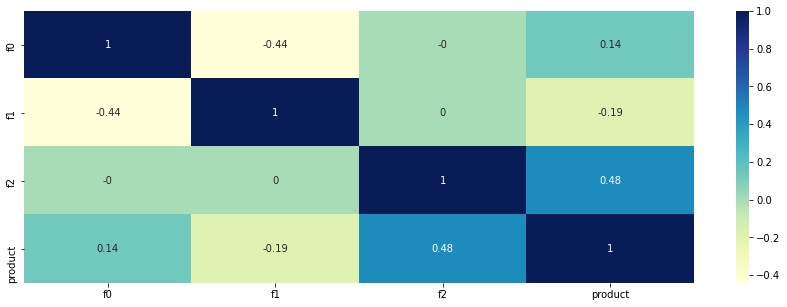

In [8]:
plt.figure(figsize=(15, 5))
sns.heatmap(data_0.corr().round(2), cmap="YlGnBu", annot=True)
plt.show()

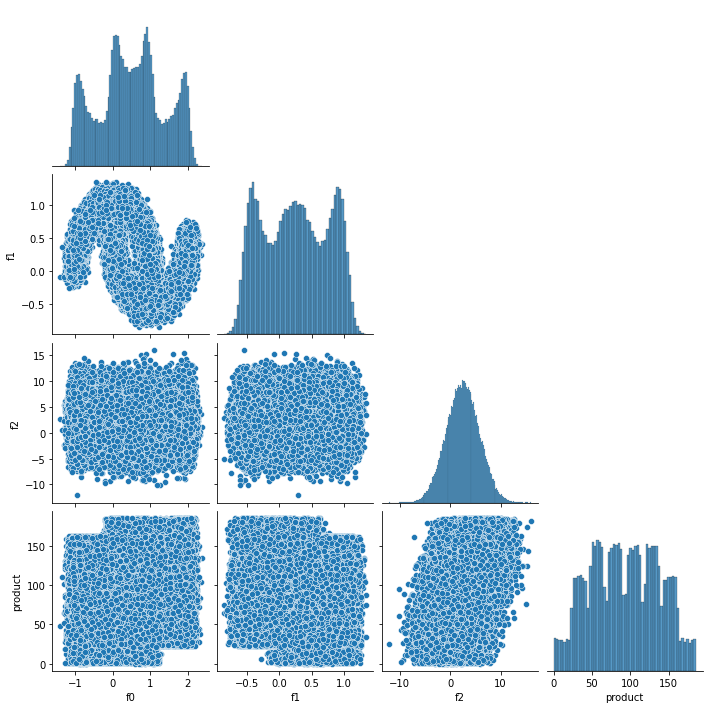

In [9]:
sns.pairplot(data_0, corner=True);

In [10]:
data_0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

- В датасете по первому региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается умеренная зависимость между f1 и f0, и между product и f2, коэффициенты корреляции -0,44 и 0,48, соответственно. Значения признака f2 распределены нормально. По нескольким скважинам в датасете присутствует несколько значений признаков.

**1.3. Изучим общую информацию по ВТОРОМУ региону.**

In [11]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
display(data_1.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
display(data_1.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


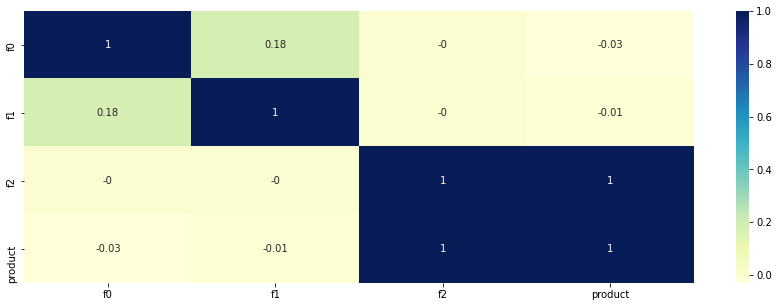

In [14]:
plt.figure(figsize=(15, 5))
sns.heatmap(data_1.corr().round(2), cmap="YlGnBu", annot=True)
plt.show()

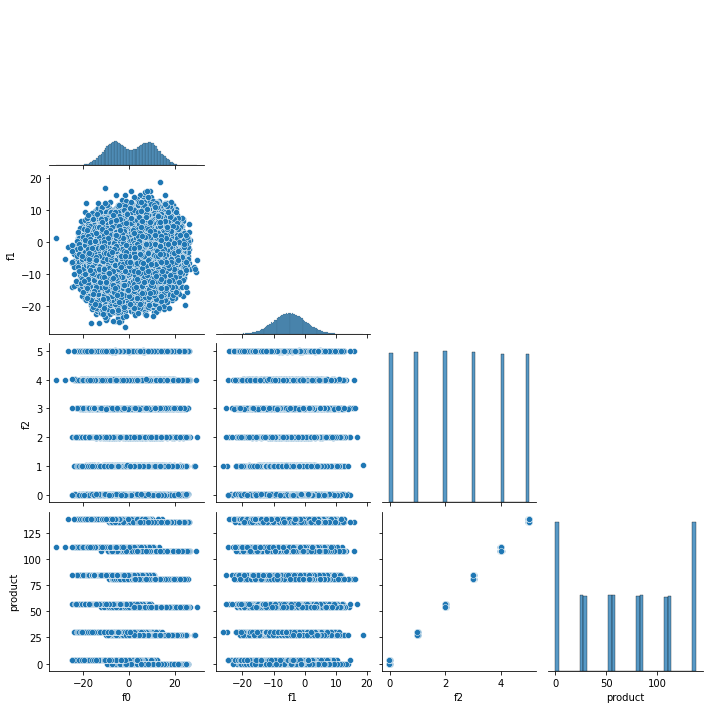

In [15]:
sns.pairplot(data_1, corner=True);

In [16]:
data_1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

- В датасете по второму региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается сильная зависимость между product и f2, коэффициент корреляции 1,0, что может значительно повлиять на метрики модели. Значения признака f1 распределены нормально. В целевом признаке всего 12 уникальных значений, возможно было применено некое осреднение запасов или отнесение скважин к определенным "категориям".

**1.4. Изучим общую информацию по ТРЕТЬЕМУ региону.**

In [17]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [18]:
display(data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [19]:
display(data_2.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


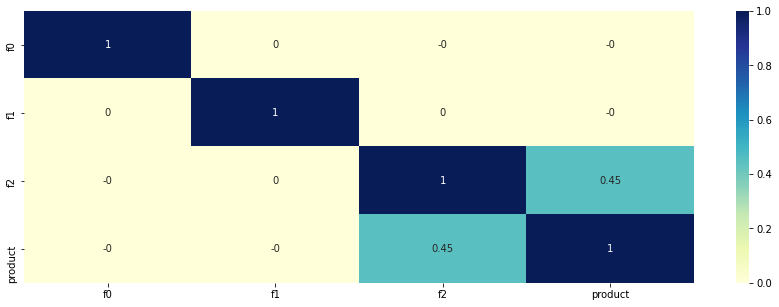

In [20]:
plt.figure(figsize=(15, 5))
sns.heatmap(data_2.corr().round(2), cmap="YlGnBu", annot=True)
plt.show()

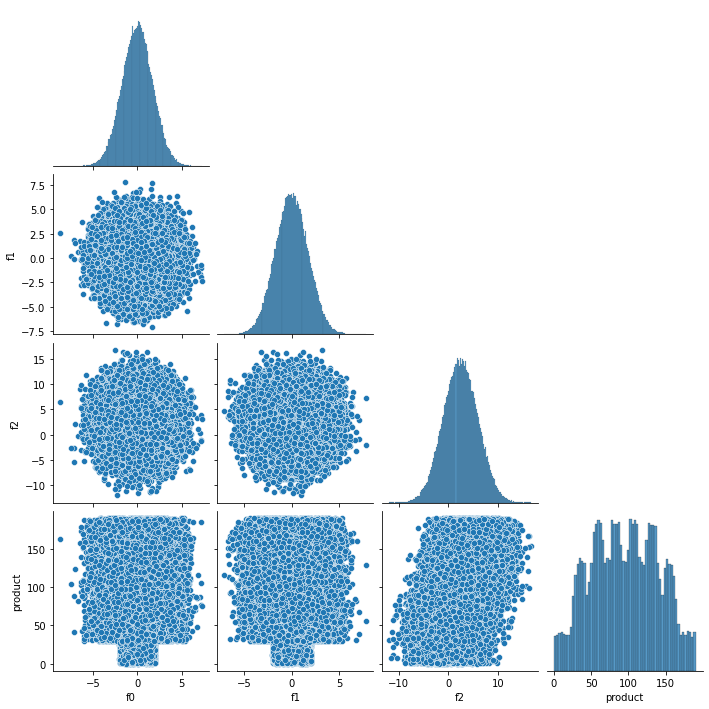

In [21]:
sns.pairplot(data_2, corner=True);

In [22]:
data_2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

- В датасете по третьему региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается умеренная зависимость между product и f2, коэффициент корреляции 0,45. Значения признаков распределены нормально. По нескольким скважинам в датасете присутствует несколько значений признаков.

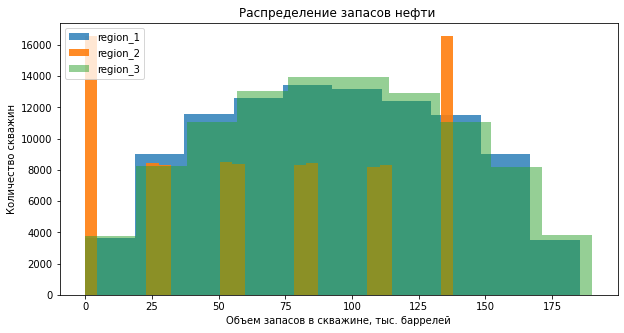

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(data_0['product'], bins = 10, alpha = 0.8, label = 'region_1')
plt.hist(data_1['product'], bins = 30, alpha = 0.9, label = 'region_2')
plt.hist(data_2['product'], bins = 10, alpha = 0.5, label = 'region_3')
plt.xlabel('Объем запасов в скважине, тыс. баррелей')
plt.ylabel('Количество скважин')
plt.title("Распределение запасов нефти ")
plt.legend(loc='upper left')
plt.show()

**Вывод**

- В датасете по первому региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается умеренная зависимость между f1 и f0, и между product и f2, коэффициенты корреляции -0,44 и 0,48, соответственно. Значения признака f2 распределены нормально. По нескольким скважинам в датасете присутствует несколько значений признаков.

- В датасете по второму региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается сильная зависимость между product и f2, коэффициент корреляции 1,0, что может значительно повлиять на метрики модели. Значения признака f1 распределены нормально. В целевом признаке всего 12 уникальных значений, возможно было применено некое осреднение запасов или отнесение скважин к определенным "категориям".

- В датасете по третьему региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается умеренная зависимость между product и f2, коэффициент корреляции 0,45. Значения признаков распределены нормально. По нескольким скважинам в датасете присутствует несколько значений признаков.

- При рассмотрении целевого признака по разным регионам на одном графике так видно, что данные по 2 региону выбиваются, а распределения данных 1 и 3 регионов похожи.

## Обучение и проверка модели

**2.1. Модель линейной регрессии для первого региона**

In [24]:
#создадим функцию разбивающую выборки и обучающую модель линейной регрессии
#признак 'id' удалим, так он будет мешать при обучении модели
def lin_reg(data, target_column):
    features = data.drop([target_column, 'id'], axis=1)
    target = data[target_column]
    
    # разобьем данные
    features_train, features_valid, target_train, target_valid  = \
    train_test_split(features, target, test_size=0.25, random_state=12345)
    
    # выполним масштабирование
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()    
    features_train[numeric] = scaler.fit_transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
        
    # обучим модель
    model = LinearRegression() 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    
    # рассчитаем метрики
    metrics = {}
    metrics['mean_predictions_valid'] = predictions_valid.mean()
    metrics['rmse'] = mean_squared_error(target_valid, predictions_valid)**0.5
    metrics['predictions_valid'] = pd.Series(predictions_valid)
    metrics['target_valid'] = target_valid.reset_index(drop=True)
     
    return metrics
   

In [25]:
import warnings
warnings.filterwarnings('ignore')

#рассчитаем метрики для каждого регоина
target_column = 'product'

metrics_0 = lin_reg(data_0, target_column)
metrics_1 = lin_reg(data_1, target_column)
metrics_2 = lin_reg(data_2, target_column)

In [26]:
print(f'Средний запас предсказанного сырья для первого региона(data_0): {metrics_0["mean_predictions_valid"]}')
print(f'RMSE для первого региона(data_0): {metrics_0["rmse"]}')
print()
print(f'Средний запас предсказанного сырья для второго региона(data_1): {metrics_1["mean_predictions_valid"]}')
print(f'RMSE для второго региона(data_1): {metrics_1["rmse"]}')
print()
print(f'Средний запас предсказанного сырья для третьего региона(data_2): {metrics_2["mean_predictions_valid"]}')
print(f'RMSE для третьего региона(data_2): {metrics_2["rmse"]}')

Средний запас предсказанного сырья для первого региона(data_0): 92.59256778438035
RMSE для первого региона(data_0): 37.5794217150813

Средний запас предсказанного сырья для второго региона(data_1): 68.728546895446
RMSE для второго региона(data_1): 0.893099286775617

Средний запас предсказанного сырья для третьего региона(data_2): 94.96504596800489
RMSE для третьего региона(data_2): 40.02970873393434


**Вывод**
- для оценки качества модели используем RMSE и сравниваем со средним запасом предсказанного сырья. Чем RMSE дальше от среднего значения и ближе к нулю тем лучше модель.
- Наименьший RMSE показала модель для второго региона, что, вероятно, связано с сильной корреляцией целевого признака с признаком 'f2'.
- RMSE моделей для первого и третьего регионов примерно одинаковы.

## Подготовка к расчёту прибыли

**3.1. Сохраним ключевые значения в отдельные переменные**

In [27]:
# сохраним в переменной 200 лучших скважин
best_wells = 200
# бюджет
budget = 10*10**9
# цена 1 тысячи баррелей нефти
price = 450*10**3

**3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.**

In [28]:
n = budget/price/best_wells
print('Достаточный объем нефти для беубыточной разработки составляет', round(n, 1), 'тыс. баррелей')

Достаточный объем нефти для беубыточной разработки составляет 111.1 тыс. баррелей


**3.3. Вывод**
- Средние значения запасов сырья на одну скважину в каждом регионе меньше 100 тыс. баррелей.
- Достаточный объем нефти для беубыточной разработки составляет 111.1 тыс. баррелей, что больше средних значений по регионам.

## Расчёт прибыли 

**Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели**

In [29]:
def profit_calculation(target_valid, predictions_valid, best_wells, price, budget):
    sorted_predictions = predictions_valid.sort_values(ascending=False)
    target_best_wells = target_valid[sorted_predictions.index][:best_wells]
    return round(((target_best_wells.sum()*price-budget)/10**9), 2)

In [30]:
print('Прибыль для полученного объема сырья для первого региона составила:', \
      profit_calculation(metrics_0['target_valid'], metrics_0['predictions_valid'], best_wells, price, budget), 'млрд рублей')
print('Прибыль для полученного объема сырья для второго региона составила:', \
      profit_calculation(metrics_1['target_valid'], metrics_1['predictions_valid'], best_wells, price, budget), 'млрд рублей')
print('Прибыль для полученного объема сырья для третьего региона составила:', \
      profit_calculation(metrics_2['target_valid'], metrics_2['predictions_valid'], best_wells, price, budget), 'млрд рублей')

Прибыль для полученного объема сырья для первого региона составила: 3.32 млрд рублей
Прибыль для полученного объема сырья для второго региона составила: 2.42 млрд рублей
Прибыль для полученного объема сырья для третьего региона составила: 2.71 млрд рублей


**В результате отбора 200 лучших скважин с максимальными предсказаниями и суммирования целевых значений объема сырья прибыль составила от 2,42 до 3,32 млрд рублей в зависимости от региона. Первый регион оказался наиболее прибыльным.**

## Оценка рисков и расчет прибыли для каждого региона

In [31]:
def bootstrap_regions(target_valid, predictions_valid, best_wells, price, budget):
        
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = target_valid.sample(500, replace=True, random_state=state)
        predictions_subsample = predictions_valid[target_subsample.index] 
        values.append(profit_calculation(target_subsample, predictions_subsample, best_wells, price, budget))

    values = pd.Series(values)
    values_mean = round(values.mean(), 3) # средняя прибыль
    upper = round(values.quantile(0.975), 3) # 97,5%-й квантиль (верхняя граница) значений прибыли
    lower = round(values.quantile(0.025), 3) # 2,5%-й квантиль (верхняя граница) значений прибыли
    risk = round((values < 0).mean() * 100, 1) # риски получить отрицательную выручку
    
    print('Средняя прибыль:', values_mean, 'млрд рублей')
    print('2,5%-квантиль - 97,5%-й квантиль:', lower, '-', upper, 'млрд рублей')
    print('Доля убытков:', risk, '%')

In [32]:
print('ПЕРВЫЙ регион:')
bootstrap_regions(metrics_0['target_valid'], metrics_0['predictions_valid'], best_wells, price, budget)

ПЕРВЫЙ регион:
Средняя прибыль: 0.426 млрд рублей
2,5%-квантиль - 97,5%-й квантиль: -0.1 - 0.95 млрд рублей
Доля убытков: 5.9 %


In [33]:
print('ВТОРОЙ регион:')
bootstrap_regions(metrics_1['target_valid'], metrics_1['predictions_valid'], best_wells, price, budget)

ВТОРОЙ регион:
Средняя прибыль: 0.515 млрд рублей
2,5%-квантиль - 97,5%-й квантиль: 0.07 - 0.93 млрд рублей
Доля убытков: 1.0 %


In [34]:
print('ТРЕТИЙ регион:')
bootstrap_regions(metrics_2['target_valid'], metrics_2['predictions_valid'], best_wells, price, budget)

ТРЕТИЙ регион:
Средняя прибыль: 0.435 млрд рублей
2,5%-квантиль - 97,5%-й квантиль: -0.13 - 0.97 млрд рублей
Доля убытков: 6.3 %


**В результате перебора 500 скважин и расчета средней прибыли, 95% доверительного интервала и доли убытков по 200 лучшим скажинам отмечается следующее:**
- Наиболее прибыльным и наименее убыточным оказался второй регион, средняя прибыль и доля убытков составляет 0,515 млрд рублей и 1 % убытков.ю соответственно.
- Наиболее убыточным является 3 регион, доля убытков 7,2%.
- Наименьшая средняя прибыль по первому региону - 0,426 млрд рублей.

## Общий вывод

**Загрузка и подготовка данных**
- В датасете по первому региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается умеренная зависимость между f1 и f0, и между product и f2, коэффициенты корреляции -0,44 и 0,48, соответственно. Значения признака f2 распределены нормально. По нескольким скважинам в датасете присутствует несколько значений признаков.
- В датасете по второму региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается сильная зависимость между product и f2, коэффициент корреляции 1,0, что может значительно повлиять на метрики модели. Значения признака f1 распределены нормально. В целевом признаке всего 12 уникальных значений, возможно было применено некое осреднение запасов или отнесение скважин к определенным "категориям".
- В датасете по третьему региону 100000 объектов, 3 признака ('f0', 'f1', 'f2') и 1 целевой признак 'product'. Пропущенных значений нет. Отмечается умеренная зависимость между product и f2, коэффициент корреляции 0,45. Значения признаков распределены нормально. По нескольким скважинам в датасете присутствует несколько значений признаков.
- При рассмотрении целевого признака по разным регионам на одном графике видно, что данные по 2 региону выбиваются, а распределения данных 1 и 3 регионов похожи.

**Обучение и проверка модели**
- Для оценки качества модели используем RMSE и сравниваем со средним запасом предсказанного сырья. Чем RMSE дальше от среднего значения и ближе к нулю тем лучше модель.
- Наименьший RMSE показала модель для второго региона (0.89), что, вероятно, связано с сильной корреляцией целевого признака с признаком 'f2'.
- RMSE моделей для первого и третьего регионов примерно одинаковы (37.6 и 40.0, соответственно).

**Подготовка к расчёту прибыли**
- Средние значения запасов сырья на одну скважину в каждом регионе меньше 100 тыс. баррелей.
- Достаточный объем нефти для беубыточной разработки составляет 111.1 тыс. баррелей, что больше средних значений по регионам.

**Оценка рисков и расчет прибыли для каждого региона**
- В результате отбора 200 лучших скважин с максимальными предсказаниями и суммирования целевых значений объема сырья прибыль составила от 2,42 до 3,32 млрд рублей в зависимости от региона. Первый регион оказался наиболее прибыльным.

**В результате перебора 500 скважин и расчета средней прибыли, 95% доверительного интервала и доли убытков по 200 лучшим скажинам отмечается следующее:**
- Наиболее прибыльным и наименее убыточным оказался второй регион, средняя прибыль и доля убытков составляет 0,515 млрд рублей и 1 % убытков.ю соответственно.
- Наиболее убыточным является 3 регион, доля убытков 7,2%.
- Наименьшая средняя прибыль по первому региону - 0,426 млрд рублей.

**В результате анализа можно утверждать что второй регион является наиболее перспективным для разработки**